<a href="https://colab.research.google.com/github/rishabhgaurav007/MiniProject/blob/master/ImageSplicing7thSem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Spliced Image Detection

*Importing a image for testing*

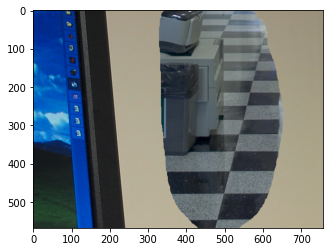

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as im
an_image = im.imread("/content/canong3_canonxt_sub_29.tif")
plt.imshow(an_image)

Preprocessing: Converting to GrayScale

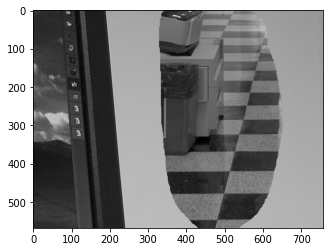

In [ ]:
import numpy as np
rgb_weights = [0.2989, 0.5870, 0.1140]

grayscale_image = np.dot(an_image[...,:3], rgb_weights)
plt.imshow(grayscale_image, cmap=plt.get_cmap("gray"))

Image Transformation To Wavelet

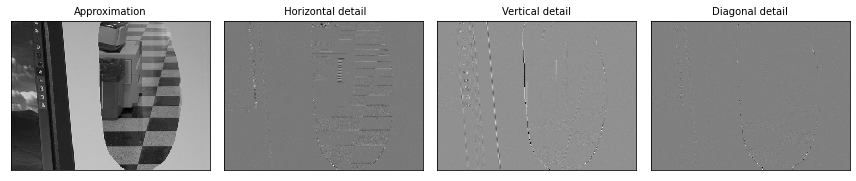

In [ ]:
import pywt
import pywt.data


# Load image
original = grayscale_image

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'db4')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [ ]:
print(original.shape)
print(LL.shape)
print(LH.shape)
# Level 1 Decomposition
# LL Aprroximation
# LH Horizontal 
# HL Vertical
# HH Diagonal

(568, 757)
(287, 382)
(287, 382)


Noise Statistics Estimation

In [ ]:
# the steps are:

#   # Wavelet transformed diagonal component 
    # has been taken from all four components.
#   # This diagonal component is got from high pass filter of columns 
    # and then high pass filter of row. 
    # Then, this diag-onal component is divided into distinct blocks 
    # of block size 2 × 2. Here, distinct means non-overlapping blocks. 
    # If the size of the image is m × n , then the number of distinct blocks will be 
    # (m/2 × n/2).
#   # Higher-order measure (using noise estimation given in the above section) 
    # calculation of each distinct block. The higher measure is defined 
    # as the fourth-order central moment (𝜇4 ) of 2 × 2 distinct block of
    # the image. These values are stored in an array.
#   # Quartile statistics of the measured samples have been calculated. 
    # To calculate quartile values, first measured sample array is sorted
    # and then calculated first (Q1), second (Q2 ) and third (Q3) quartile 
    # values of the sorted array.
#   # Resultant samples values are converted into binary values using the
    # threshold (th) value chosen from quartile value

In [ ]:
# Input: cD: Diagonal Coefficient of Transformed Image, BS:2 //Block Size
# Output: N: Resultant Noise Statistic Image
# functions:
    # DivideBlocks: Division of Input Image into BS*BS blocks
    # Count: To count the size of input array
    # Sort: To sort the given array
    # Search: Find the elements using given logical operation
    # Median: Calculate Median of the input sequence
from scipy.stats import moment
import statistics

def noise_estimation(cD,BS=2):
  # mapping the noise estimated values N to image
  def mappertoimage(cD,FOCM,th):
    shape = cD.shape
    temp = cD.copy()
    x_len = shape[0]
    y_len = shape[1]
    for i in range(0,x_len):
      for j in range(0,y_len):
        temp[i][j] = 0
    if x_len%2 == 1:
      x_len = x_len-1;
    if y_len%2 == 1:
      y_len = y_len-1;
    current =0
    for i in range(0,x_len,2):
      for j in range(0,y_len,2):
        value=1
        if FOCM[current]>th:
          value = 0
        current=current+1
        temp[i][j] = temp[i+1][j] = temp[i][j+1] = temp[i+1][j+1] = value
    return temp
    

  # divide the input image into blocks of size BS*BS
  def DivideBlocks(cD,BS):
    shape = cD.shape
    x_len = shape[0]
    y_len = shape[1]
    if x_len%2 == 1:
      x_len = x_len-1;
    if y_len%2 == 1:
      y_len = y_len-1;
    Blocks = np.zeros(((int)(x_len/2), (int)(y_len/2), 4))
    for i in range(0,x_len,2):
      for j in range(0,y_len,2):
        i2 = (int)(i/2)
        j2 = (int)(j/2)
        Blocks[i2][j2][0] = cD[i][j]
        Blocks[i2][j2][1] = cD[i][j+1]
        Blocks[i2][j2][2] = cD[i+1][j]
        Blocks[i2][j2][3] = cD[i+1][j+1]
    return Blocks
  
  # Returns Fourth Order central Moment values
  def CalculateMoment(Blocks,order):
    FOCM = []
    for i in Blocks:
      for j in i:
        temp_mom = moment(j, moment=order)
        FOCM.append(temp_mom)
    return FOCM

  # Driving the code here  
  Blocks = DivideBlocks(cD,BS)
  # to calculate moment of 4 sized block FOCM
  FOCM = CalculateMoment(Blocks,4) 
  # size of FOCM
  n = len(FOCM) 
  # sort the moment
  sFOCM = FOCM.copy()
  sFOCM.sort()
  # Calculating the quartile statistics
  q1=0
  q2=0
  q3=0
  if n%2 == 1:
    q2 = sFOCM[(int)(n/2)]
  else:
    q2 = (sFOCM[(int)((n-1)/2)] + sFOCM[(int)(n/2)])/2

  less_thanq2 = []
  more_thanq2 = []

  for i in sFOCM:
    if i>q2:
      more_thanq2.append(i)
    elif i<q2:
      less_thanq2.append(i)
  q1 = statistics.median(less_thanq2)
  q3 = statistics.median(more_thanq2)
  th = q3
  return mappertoimage(cD,FOCM,th)
  

In [ ]:
N=noise_estimation(LH)


**Post Preprocessing**

Algo

In [ ]:
# Dilation operation of the mapped image is performed using the following structuring element.
# SE= 1 0 1
#     0 1 0
#     1 0 1 
# Hole filling is performed to fill the inaccurate pixels with the background pixel value.
# Removed small objects which are lesser than assumed spliced region size. 
# Erosion is performed to correct the border pixels of the spliced region.

Dilation Erosion



In [ ]:
from skimage.morphology import erosion, dilation

In [ ]:
kernel = np.ones((3,3), np.uint8) 
"""kernel[0][1] = 0
kernel[1][0] = 0
kernel[1][2] = 0
kernel[2][1] = 0  
print(kernel)
"""
dilated = dilation(N)
eroded = erosion(dilated)

In [ ]:
#from scipy import ndimage
#filled = ndimage.binary_fill_holes(dilated).astype(int).astype(float)
#plt.imshow(np.real(filled),cmap=plt.cm.gray)

Plotting

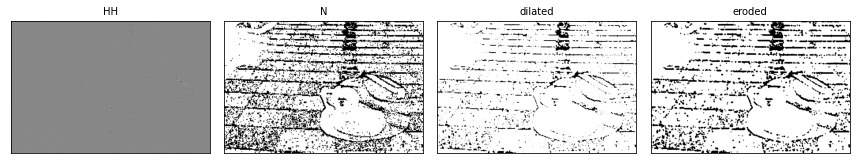

In [ ]:
titles = ['HH','N','dilated','eroded']
fig = plt.figure(figsize=(12, 3))
for i,a in enumerate([HH,N,dilated,eroded]):
  ax = fig.add_subplot(1,4,i+1)
  ax.imshow(a, cmap=plt.cm.gray)
  ax.set_title(titles[i], fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

fig.tight_layout()
plt.show()

In [ ]:
from PIL import Image


img = an_image

background = eroded

background.paste(img, (0, 0), img)
background.save('how_to_superimpose_two_images_01.png',"PNG")

AttributeError: ignored